# ⚙️ Notebook 02 — Processamento de Dados (ETL)

Neste notebook é realizada a etapa de **processamento e preparação dos dados**
para modelagem de crédito. Partindo do dataset analisado no notebook de EDA,
foram aplicadas técnicas de **ETL (Extract, Transform, Load)**, com foco em
tornar as variáveis adequadas para algoritmos de machine learning.

As principais etapas incluem:

- Tratamento e padronização de variáveis numéricas
- Engenharia de atributos baseada em lógica de negócio
- Criação de faixas (binning) supervisionadas
- Normalização dos dados com **MinMaxScaler**
- Codificação de variáveis categóricas via **One-Hot Encoding**

Ao final do processo, o dataset é consolidado e salvo em formato estruturado,
pronto para ser utilizado no notebook seguinte de **modelagem e avaliação de risco de crédito**.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
# Importando os dados para transformação
df = pd.read_csv('../data/credit_risk_dataset.csv')

# Garantindo a padronização do nome das colunas
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
    .str.replace(' ', '_')
)

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Tratamento de Inconsistências e Outliers (Validação de Regras de Negócio)

Durante a Análise Exploratória de Dados (EDA), foram identificados valores numéricos inconsistentes que caracterizam **erros de cadastro**, e não outliers legítimos do fenômeno estudado. Esses registros, se mantidos, poderiam distorcer métricas estatísticas e impactar negativamente as etapas subsequentes de imputação e modelagem.

Dessa forma, optou-se por aplicar **regras de negócio** para validação da consistência dos dados, removendo observações claramente inválidas antes do tratamento de valores ausentes.

### Regras de Negócio Aplicadas

- **Idade (`person_age`)**: valores superiores a 100 anos foram considerados inconsistentes, pois fogem da expectativa demográfica plausível.
- **Tempo de emprego (`person_emp_length`)**: valores superiores a 60 anos foram considerados inválidos, uma vez que são incompatíveis com a trajetória profissional típica de um indivíduo.

Essa abordagem garante que estatísticas como mediana e quartis, utilizadas posteriormente no tratamento de valores ausentes, não sejam contaminadas por dados incorretos.

### Aplicação das Regras

```python
df = df.query(
    'person_age < 100 and person_emp_length < 60'
)

In [6]:
# Utilizando o query para filtrar os valores fora do comum
df = df.query('person_age < 100 and person_emp_length < 60')

## Criação de Flags de Dados Faltantes

As flags de dados faltantes foram criadas **antes da imputação**, garantindo
a preservação da informação associada à ausência de dados.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31679 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31679 non-null  int64  
 1   person_income               31679 non-null  int64  
 2   person_home_ownership       31679 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 31679 non-null  object 
 5   loan_grade                  31679 non-null  object 
 6   loan_amnt                   31679 non-null  int64  
 7   loan_int_rate               28632 non-null  float64
 8   loan_status                 31679 non-null  int64  
 9   loan_percent_income         31679 non-null  float64
 10  cb_person_default_on_file   31679 non-null  object 
 11  cb_person_cred_hist_length  31679 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


In [8]:
# Criando as Flags para dados ausentes
df['flag_missing_int_rate'] = df['loan_int_rate'].isna().astype(int)

## Tratamento de Valores Ausentes (Missing Values)

Após a validação das regras de negócio e remoção de registros inconsistentes, foi realizada a análise e o tratamento dos valores ausentes. O tratamento foi definido de forma **contextual**, considerando o significado de cada variável no problema de crédito.

A abordagem adotada evita imputações genéricas e busca preservar a coerência dos dados em relação ao comportamento esperado do cliente.

---

### Análise dos Valores Ausentes

Foram identificadas colunas com valores nulos, sendo tratadas conforme sua natureza e impacto no modelo. As estratégias adotadas diferem entre variáveis que representam **ausência de informação válida** e variáveis numéricas com **dependência de contexto de risco**.

---

### Tratamento da Variável `person_emp_length`

A variável `person_emp_length` representa o tempo de permanência do indivíduo em seu emprego atual. Valores nulos nessa coluna indicam ausência de histórico de trabalho válido ou informação não declarada.

Nesses casos, optou-se por imputar o valor **0 (zero)**, representando explicitamente a inexistência de vínculo empregatício registrado, ao invés de utilizar medidas estatísticas como média ou mediana.


In [9]:
# Tratando valores Null na coluna 'person_emp_length' como 0 (zero), significando que mão tem histórico de trabalho valido
df['person_emp_length'] = df['person_emp_length'].fillna(0)

### Tratamento da Variável `loan_int_rate`

A variável `loan_int_rate` representa a taxa de juros do empréstimo e apresenta dependência direta do nível de risco do cliente, representado pela variável loan_grade.

Dessa forma, optou-se por imputar os valores ausentes utilizando a **mediana** da taxa de juros por grupo de risco, preservando a relação entre risco e precificação do crédito.

In [10]:
df['loan_int_rate'] = df['loan_int_rate'].fillna(
    df.groupby('loan_grade')['loan_int_rate'].transform('median')
)

## Criação de Faixas Etárias (Age Binning)

Com o objetivo de capturar possíveis relações não lineares entre a idade do
cliente (`person_age`) e a inadimplência, foi realizada uma discretização
inicial da variável utilizando quantis.

A utilização de quantis permite:
- Distribuição equilibrada de observações por faixa
- Avaliação supervisionada baseada no comportamento do target
- Redução da influência de outliers residuais

In [11]:
# Criando bins iniciais por quantis
df['age_bin_raw'] = pd.qcut(
    df['person_age'],
    q=5,
    duplicates='drop'
)

age_default_summary = (
    df
    .groupby('age_bin_raw', observed=True)['loan_status']
    .value_counts(normalize=True)
    .unstack()
    .reset_index()
)

## Definição Final das Faixas Etárias

Com base na análise supervisionada das taxas de inadimplência por quantis de
idade, foram definidas faixas etárias finais que apresentam comportamento
homogêneo de risco dentro de cada grupo.

As faixas foram ajustadas para:
- Garantir interpretabilidade de negócio
- Preservar diferenças relevantes de risco
- Evitar fragmentação excessiva da variável

In [12]:
# Criação da feature final de faixa etária baseada em análise supervisionada
bins_age = [df['person_age'].min(), 23, 27, 32, df['person_age'].max()]
labels_age = [
    '19-23',
    '24-27',
    '28-32',
    '33+'
]

df['age_bin'] = pd.cut(
    df['person_age'],
    bins=bins_age,
    labels=labels_age,
    right=True
)

df['age_bin'] = df['age_bin'].astype('object')

# Excluindo a coluna usada para analise
'''df.drop(
    columns=[
        'age_bin_raw',
    ],
    errors='ignore',
    inplace=True
)'''

"df.drop(\n    columns=[\n        'age_bin_raw',\n    ],\n    errors='ignore',\n    inplace=True\n)"

## Definição Final das Faixas de Renda

A variável de renda foi discretizada com base em análise supervisionada,
visando capturar relações não lineares com a inadimplência e melhorar a
interpretabilidade do modelo.


In [13]:
# Criando bins iniciais por quantis
df['age_bin_raw'] = pd.qcut(
    df['person_age'],
    q=5,
    duplicates='drop'
)

age_default_summary = (
    df
    .groupby('age_bin_raw', observed=True)['loan_status']
    .value_counts(normalize=True)
    .unstack()
    .reset_index()
)

## Criação de Faixas de Renda (`person_income`)

Como parte do *feature engineering*, foi realizada a discretização da variável
`person_income` em faixas (*binning*), com o objetivo de:

- Capturar **relações não lineares** entre renda e inadimplência  
- Melhorar a **interpretabilidade** do modelo  
- Reduzir sensibilidade a outliers extremos  
- Criar uma variável mais alinhada à **análise de risco de crédito**

As faixas foram definidas de forma **híbrida**, combinando:
- Análise supervisionada (taxa de inadimplência por quantis)
- Critério de negócio (níveis de renda usuais no mercado)

In [14]:
bins_income = [
    df['person_income'].min(),
    35000,
    50000,
    64000,
    87000,
    df['person_income'].max()
]

labels_income = [
    'Up to 35k',
    '35k-50k',
    '50k-64k',
    '64k-87k',
    '87k+'
]

df['income_bin'] = pd.cut(
    df['person_income'],
    bins=bins_income,
    labels=labels_income,
    include_lowest=True
)

df['income_bin'] = df['income_bin'].astype('object')


## Feature de Interação: Renda × Tempo de Emprego

Para capturar a relação conjunta entre **capacidade financeira** e **estabilidade
profissional**, foi criada uma variável de interação entre:

- `person_income` (renda anual)
- `person_emp_length` (tempo de emprego)

Essa interação busca representar, de forma aproximada, o **potencial econômico
acumulado** do indivíduo, indo além da análise isolada de cada variável.

### Criação da variável de interação com transformação logarítmica

Como o produto dessas variáveis pode gerar valores altamente assimétricos,
foi aplicada a transformação `log1p`, que:

- Reduz a influência de valores extremos  
- Mantém observações com valor zero  
- Melhora a estabilidade de modelos lineares  

In [15]:
df['income_emp_interaction_log'] = np.log1p(
    df['person_income'] * df['person_emp_length']
)

## Feature de Capacidade de Pagamento (Capacity to Loan Ratio)

Com o objetivo de estimar a **capacidade relativa do cliente em honrar o empréstimo**,
foi criada uma variável que relaciona:

- Potencial econômico do indivíduo (renda × tempo de emprego)
- Valor solicitado no empréstimo

Essa métrica busca responder, de forma aproximada:
> *“O tamanho do empréstimo é compatível com a capacidade financeira do cliente?”*

In [16]:
df['capacity_to_loan_ratio'] = (
    (df['person_income'] * df['person_emp_length']) /
    (df['loan_amnt'] + 1)
)

df['capacity_to_loan_ratio_log'] = np.log1p(
    df['capacity_to_loan_ratio']
)

df.drop(
    columns='capacity_to_loan_ratio',
    inplace=True
)

In [17]:
df['capacity_to_loan_bin'] = pd.qcut(
    df['capacity_to_loan_ratio_log'],
    q=5,
    duplicates='drop'
)


# 5. Cálculo da taxa de inadimplência por faixa
capacity_analysis = (
    df
        .groupby('capacity_to_loan_bin', observed=True)['loan_status']
        .value_counts(normalize=True)
        .unstack()
        .reset_index()
)

capacity_analysis.columns = [
    'capacity_to_loan_bin',
    'Non-Default Rate',
    'Default Rate'
]

capacity_analysis


,capacity_to_loan_bin,Non-Default Rate,Default Rate
0,"(-0.001, 2.068]",0.656250,0.343750
1,"(2.068, 2.973]",0.694650,0.305350
2,"(2.973, 3.559]",0.804231,0.195769
3,"(3.559, 4.227]",0.870896,0.129104
4,"(4.227, 9.051]",0.896780,0.103220


## Validação Final – Capacity to Loan Ratio (3 Faixas)

Após a consolidação da variável `capacity_to_loan_ratio_log` em três faixas,
foi realizada a validação da taxa de inadimplência por grupo.

In [18]:
bins_capacity = [
    df['capacity_to_loan_ratio_log'].min(),
    2.973,
    4.227,
    df['capacity_to_loan_ratio_log'].max()
]

labels_capacity = [
    'Low Capacity',
    'Medium Capacity',
    'High Capacity'
]

df['capacity_to_loan_bin_final'] = pd.cut(
    df['capacity_to_loan_ratio_log'],
    bins=bins_capacity,
    labels=labels_capacity,
    include_lowest=True
)

df['capacity_to_loan_bin_final'] = df['capacity_to_loan_bin_final'].astype('object')

In [21]:
capacity_final_analysis = (
    df
        .groupby('capacity_to_loan_bin_final', observed=True)['loan_status']
        .value_counts(normalize=True)
        .unstack()
        .reset_index()
)

capacity_final_analysis.columns = [
    'capacity_to_loan_bin_final',
    'Non-Default Rate',
    'Default Rate'
]

capacity_final_analysis


,capacity_to_loan_bin_final,Non-Default Rate,Default Rate
0,High Capacity,0.896628,0.103372
1,Low Capacity,0.675454,0.324546
2,Medium Capacity,0.837693,0.162307


## Definição das Faixas Finais – Capacidade de Pagamento

Após a análise supervisionada da variável
`capacity_to_loan_ratio_log`, observou-se uma **relação monótona**:
quanto maior a capacidade relativa de pagamento, menor a taxa de inadimplência.

Com base nessa evidência estatística e em critérios de negócio,
foram definidas faixas finais mais **estáveis e interpretáveis**,
evitando excesso de granularidade.


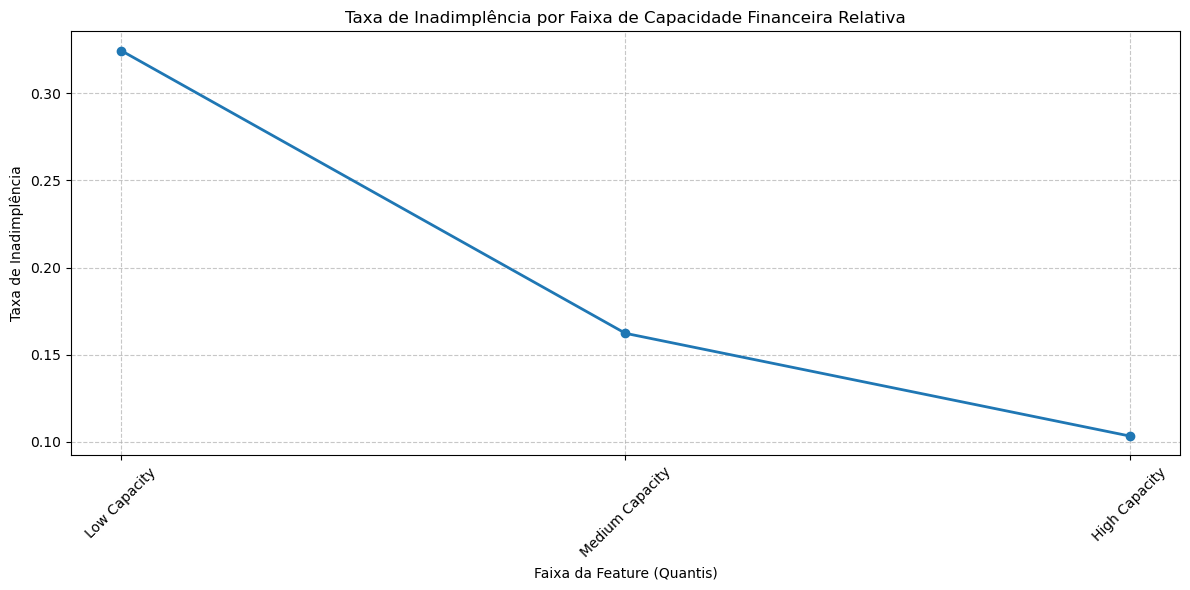

In [22]:
# 1. Definindo a ordem lógica correta
ordem_capacidade = ['Low Capacity', 'Medium Capacity', 'High Capacity']

# 2. Transformando a coluna em categórica com a ordem definida
capacity_final_analysis['capacity_to_loan_bin_final'] = pd.Categorical(
    capacity_final_analysis['capacity_to_loan_bin_final'], 
    categories=ordem_capacidade, 
    ordered=True
)

# 3. Ordenar o DataFrame pela nova lógica da coluna
capacity_final_analysis = capacity_final_analysis.sort_values('capacity_to_loan_bin_final')

# --- Plotagem ---
plt.figure(figsize=(12, 6))

plt.plot(
    capacity_final_analysis['capacity_to_loan_bin_final'].astype(str), # Agora a string segue a ordem do DF ordenado
    capacity_final_analysis['Default Rate'],
    marker='o',
    linestyle='-', # Garante a linha conectando os pontos na ordem certa
    linewidth=2
)

plt.title('Taxa de Inadimplência por Faixa de Capacidade Financeira Relativa')
plt.xlabel('Faixa da Feature (Quantis)')
plt.ylabel('Taxa de Inadimplência')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Evita que os labels rotacionados cortem na imagem
plt.show()


## Análise de Multicolinearidade (VIF)

A análise de multicolinearidade foi realizada utilizando o
*Variance Inflation Factor (VIF)*, considerando apenas as variáveis
numéricas contínuas.

Variáveis categóricas e bins foram excluídos desta etapa.

In [23]:
# Selecionando apenas variáveis numéricas
num_features = df.select_dtypes(include=['int64', 'float64']).copy()

# Removendo target e flags binárias do VIF
num_features = num_features.drop(
    columns=[
        'flag_missing_emp_length',
        'flag_missing_int_rate',
        'income_emp_interaction_log',
        'person_age'
    ],
    errors='ignore'
)

num_features.head()

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,capacity_to_loan_ratio_log
1,9600,5.0,1000,11.14,0,0.10,2,3.890841
2,9600,1.0,5500,12.87,1,0.57,3,1.009831
3,65500,4.0,35000,15.23,1,0.53,2,2.138359
4,54400,8.0,35000,14.27,1,0.55,4,2.597784
5,9900,2.0,2500,7.14,1,0.25,2,2.187941


### Cálculo do VIF

In [24]:
vif_df = pd.DataFrame()
vif_df['feature'] = num_features.columns
vif_df['VIF'] = [
    variance_inflation_factor(num_features.values, i)
    for i in range(num_features.shape[1])
]

vif_df.sort_values(by='VIF', ascending=False)

,feature,VIF
7,capacity_to_loan_ratio_log,11.427342
3,loan_int_rate,8.955545
2,loan_amnt,8.495707
5,loan_percent_income,7.853554
1,person_emp_length,6.086225
0,person_income,4.483925
6,cb_person_cred_hist_length,2.995869
4,loan_status,1.644045


## Análise de Correlação

In [25]:
corr_matrix = num_features.corr()

corr_matrix

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,capacity_to_loan_ratio_log
person_income,1.000000,0.154746,0.314667,-0.008363,-0.164128,-0.293433,0.124272,0.247770
person_emp_length,0.154746,1.000000,0.110993,-0.055430,-0.085966,-0.058559,0.149404,0.744495
loan_amnt,0.314667,0.110993,1.000000,0.141205,0.112188,0.577004,0.042678,-0.143049
loan_int_rate,-0.008363,-0.055430,0.141205,1.000000,0.337905,0.123626,0.014715,-0.087243
loan_status,-0.164128,-0.085966,0.112188,0.337905,1.000000,0.379823,-0.016830,-0.193756
loan_percent_income,-0.293433,-0.058559,0.577004,0.123626,0.379823,1.000000,-0.030683,-0.386745
cb_person_cred_hist_length,0.124272,0.149404,0.042678,0.014715,-0.016830,-0.030683,1.000000,0.057192
capacity_to_loan_ratio_log,0.247770,0.744495,-0.143049,-0.087243,-0.193756,-0.386745,0.057192,1.000000


### Conclusão da Análise de Multicolinearidade

A análise de VIF e correlação foi utilizada como ferramenta diagnóstica,
não como critério automático de exclusão.

Variáveis altamente correlacionadas foram avaliadas sob a ótica de:
- interpretação
- estabilidade do modelo
- redundância de informação

As decisões finais de manutenção ou remoção foram realizadas considerando
o tipo de modelo (Regressão Logística vs Random Forest).

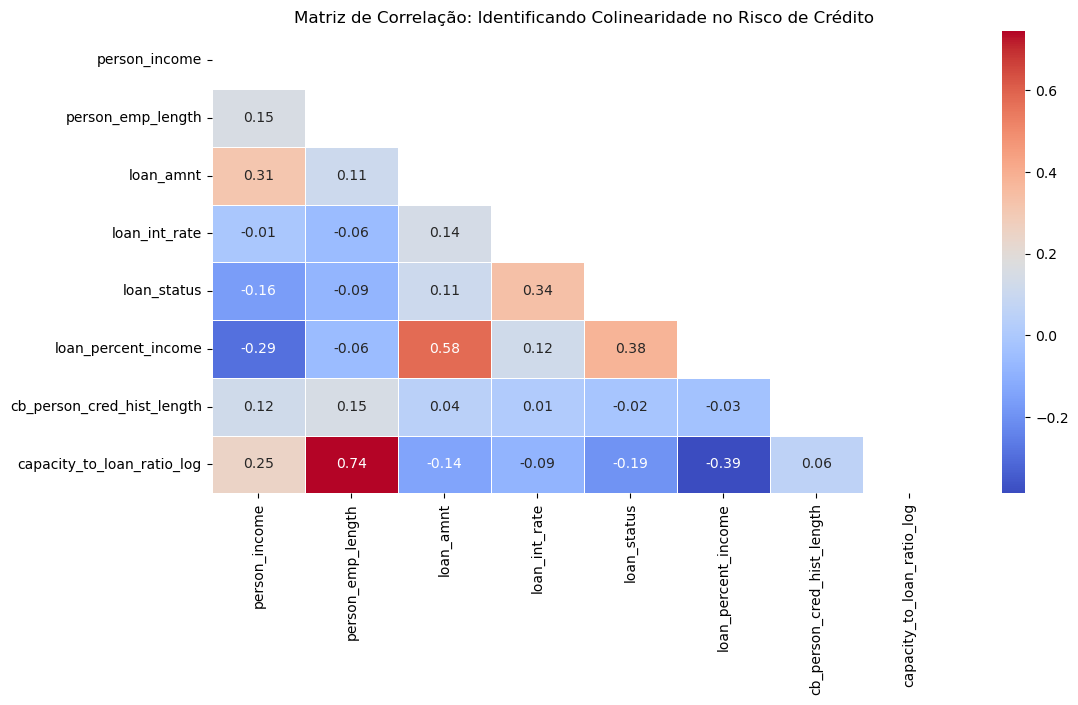

In [27]:
# Configurando o estilo
plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(num_features.corr(), dtype=bool)) # Máscara para ver apenas metade (evita repetição)

sns.heatmap(
    num_features.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    mask=mask,
    linewidths=0.5
)

plt.title('Matriz de Correlação: Identificando Colinearidade no Risco de Crédito')
plt.show()

In [28]:
# Excluindo colunas teste
df = df.drop(columns=['age_bin_raw', 'capacity_to_loan_bin'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31679 entries, 1 to 32580
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31679 non-null  int64  
 1   person_income               31679 non-null  int64  
 2   person_home_ownership       31679 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 31679 non-null  object 
 5   loan_grade                  31679 non-null  object 
 6   loan_amnt                   31679 non-null  int64  
 7   loan_int_rate               31679 non-null  float64
 8   loan_status                 31679 non-null  int64  
 9   loan_percent_income         31679 non-null  float64
 10  cb_person_default_on_file   31679 non-null  object 
 11  cb_person_cred_hist_length  31679 non-null  int64  
 12  flag_missing_int_rate       31679 non-null  int32  
 13  age_bin                     31664 no

## Preparação Final dos Dados para Modelagem

Nesta etapa final do pré-processamento, os dados são preparados para
alimentar modelos de Machine Learning, garantindo consistência,
escalonamento adequado e tratamento correto de variáveis categóricas.

O objetivo é gerar uma base final pronta para:
- Regressão Logística
- Random Forest
- Avaliação comparativa de desempenho

---

### Separação da variável target

A variável `loan_status` foi definida como *target* do problema,
sendo separada das variáveis explicativas.

In [30]:
# Selecionando a target para separação do dataset
target = 'loan_status'

# Usamos .copy() para evitar o aviso SettingWithCopyWarning
y = df[target].copy()
X = df.drop(columns=[target])

# 2. Agora pegamos as colunas do X por tipo sem o risco de incluir a target
colunas_numericas = X.select_dtypes(include=['number']).columns.tolist()
colunas_categoricas = X.select_dtypes(include=['object']).columns.tolist()

# Remove colunas que são números mas não são variáveis preditivas
'''if '' in colunas_numericas:
    colunas_numericas.remove('')'''

"if '' in colunas_numericas:\n    colunas_numericas.remove('')"

## Padronização, Codificação e Ajustes Finais das Features

Nesta etapa final do processamento, as variáveis são transformadas para
um formato totalmente numérico, compatível com algoritmos de machine learning.

### **Variáveis Numéricas**
As variáveis numéricas foram normalizadas utilizando o **MinMaxScaler**,
que reescala os valores para o intervalo \([0, 1]\).

Essa abordagem é especialmente importante para modelos sensíveis à escala
dos dados, como regressão logística, KNN e modelos baseados em distância.

### **Variáveis Categóricas**
As variáveis categóricas foram convertidas em variáveis dummy
(*one-hot encoding*).

Foi utilizado o parâmetro `drop_first=True` para evitar o problema de
multicolinearidade conhecido como *dummy variable trap*.

Após a criação das dummies, algumas colunas passam a ser do tipo booleano.
Essas variáveis foram convertidas para valores binários (0 e 1),
garantindo compatibilidade total com os algoritmos de modelagem.

In [31]:
scaler = MinMaxScaler()
X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])

X = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# Seleciona apenas as colunas booleanas e as converte
cols_bool = X.select_dtypes(include=['bool']).columns
X[cols_bool] = X[cols_bool].astype(int)

print("ETL concluído com sucesso!")
print(f"Formato final de X: {X.shape}")

ETL concluído com sucesso!
Formato final de X: (31679, 34)


Por fim, foi realizada uma checagem do pipeline de ETL,
confirmando que o processamento foi concluído com sucesso
e verificando o formato final da matriz de features.

In [32]:
# Removendo features que tem muita correlação segundo o VIF
X = X.drop(
    columns=[
        'income_emp_interaction_log',
        'person_age'
    ],
    errors='ignore'
)

In [33]:
X.head()

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,flag_missing_int_rate,capacity_to_loan_ratio_log,person_home_ownership_OTHER,person_home_ownership_OWN,...,cb_person_default_on_file_Y,age_bin_24-27,age_bin_28-32,age_bin_33+,income_bin_50k-64k,income_bin_64k-87k,income_bin_87k+,income_bin_Up to 35k,capacity_to_loan_bin_final_Low Capacity,capacity_to_loan_bin_final_Medium Capacity
1,0.002751,0.121951,0.014493,0.321348,0.120482,0.000000,0.0,0.429870,0,1,...,0,0,0,0,0,0,0,1,0,1
2,0.002751,0.024390,0.144928,0.418539,0.686747,0.035714,0.0,0.111569,0,0,...,0,1,0,0,0,0,0,1,1,0
3,0.030209,0.097561,1.000000,0.551124,0.638554,0.000000,0.0,0.236252,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.024757,0.195122,1.000000,0.497191,0.662651,0.071429,0.0,0.287010,0,0,...,1,1,0,0,1,0,0,0,1,0
5,0.002898,0.048780,0.057971,0.096629,0.301205,0.000000,0.0,0.241729,0,1,...,0,0,0,0,0,0,0,1,1,0


In [34]:
# Avaliando o dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31679 entries, 1 to 32580
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   person_income                               31679 non-null  float64
 1   person_emp_length                           31679 non-null  float64
 2   loan_amnt                                   31679 non-null  float64
 3   loan_int_rate                               31679 non-null  float64
 4   loan_percent_income                         31679 non-null  float64
 5   cb_person_cred_hist_length                  31679 non-null  float64
 6   flag_missing_int_rate                       31679 non-null  float64
 7   capacity_to_loan_ratio_log                  31679 non-null  float64
 8   person_home_ownership_OTHER                 31679 non-null  int32  
 9   person_home_ownership_OWN                   31679 non-null  int32  
 10  person_home_own

In [35]:
# Retorna um objeto Index do Pandas
print(X.columns)

# Todas as features do dataset
print(X.columns.tolist())

Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length',
       'flag_missing_int_rate', 'capacity_to_loan_ratio_log',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y', 'age_bin_24-27',
       'age_bin_28-32', 'age_bin_33+', 'income_bin_50k-64k',
       'income_bin_64k-87k', 'income_bin_87k+', 'income_bin_Up to 35k',
       'capacity_to_loan_bin_final_Low Capacity',
       'capacity_to_loan_bin_final_Medium Capacity'],
      dtype='object')
['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'flag_missing_int_ra

Com essas transformações, o conjunto de dados encontra-se totalmente
preparado para a etapa de modelagem, com variáveis normalizadas,
codificadas e livres de inconsistências de tipo.

## Consolidação e Salvamento do Dataset Final

Após todas as etapas de limpeza, transformação, engenharia de atributos,
normalização e codificação, o conjunto de dados final foi consolidado
em um único DataFrame, pronto para uso em modelos de machine learning.

In [36]:
# Concatenar para salvar um arquivo único processado para o modelo
df_final = X.copy()
df_final['target'] = y

df_final.to_csv('../data/credit_risk_processed.csv', index=False)

Com isso, o pipeline de ETL e feature engineering é finalizado.
O dataset está completamente preparado para a próxima etapa do projeto,
onde serão aplicados e avaliados diferentes modelos de crédito,
incluindo métricas de performance e análise de risco.

➡️ **Próximo notebook:** Modelagem e Avaliação dos Modelos